In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator

from scipy.stats import ttest_ind

%matplotlib inline

In [3]:
# read offense data
offense = pd.read_csv('data/offense.csv')
# read defense data
defense = pd.read_csv('data/defense.csv')
# read salary data
salary = pd.read_csv('data/salary.csv', index_col=0)
# change columns (uppercase first letter) to match the other data
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
# read standings data
standings = pd.read_csv('data/standings.csv')

Need to fix the offense and defense stats so that they are the previous year. Can do this by adding 1 to the year before merging the datasets. Salary is known at the beginning of the season so the year doesn't have to change.

In [4]:
offense['Year'] += 1
defense['Year'] += 1

In [6]:
# merge the offense and defense data with suffixes
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
# merge the salary data
combined = pd.merge(combined, salary, on=['Team', 'Year'])
# merge the standings dataframe - use left so 2018 data stays
combined = pd.merge(combined, standings, on=['Team', 'Year'], how='left')

combined.head()

,Team,Year,Yds/G_rush_off,TD_rush_off,Yds/G_pass_off,Pct_off,TD_pass_off,Sck_off,Rate_off,Pts/G_off,...,nTE,nWR,W,L,T,PF,PA,DIFF,Playoffs,SB_win
0,WAS,2013,169.3,22.0,213.9,65.8,24.0,33.0,102.1,27.2,...,4.0,8.0,3.0,13.0,0.0,334.0,478.0,-144.0,0.0,0.0
1,MIN,2013,164.6,16.0,171.9,62.1,18.0,32.0,81.2,23.7,...,4.0,6.0,5.0,10.0,1.0,391.0,480.0,-89.0,0.0,0.0
2,SEA,2013,161.2,16.0,189.4,64.0,27.0,33.0,100.6,25.8,...,4.0,7.0,13.0,3.0,0.0,417.0,231.0,186.0,1.0,1.0
3,SF,2013,155.7,17.0,206.1,66.3,23.0,41.0,101.2,24.8,...,4.0,7.0,12.0,4.0,0.0,406.0,272.0,134.0,1.0,0.0
4,KC,2013,149.7,9.0,169.6,57.5,8.0,40.0,63.8,13.2,...,5.0,6.0,11.0,5.0,0.0,430.0,305.0,125.0,1.0,0.0


## Correlation of Independent Variables

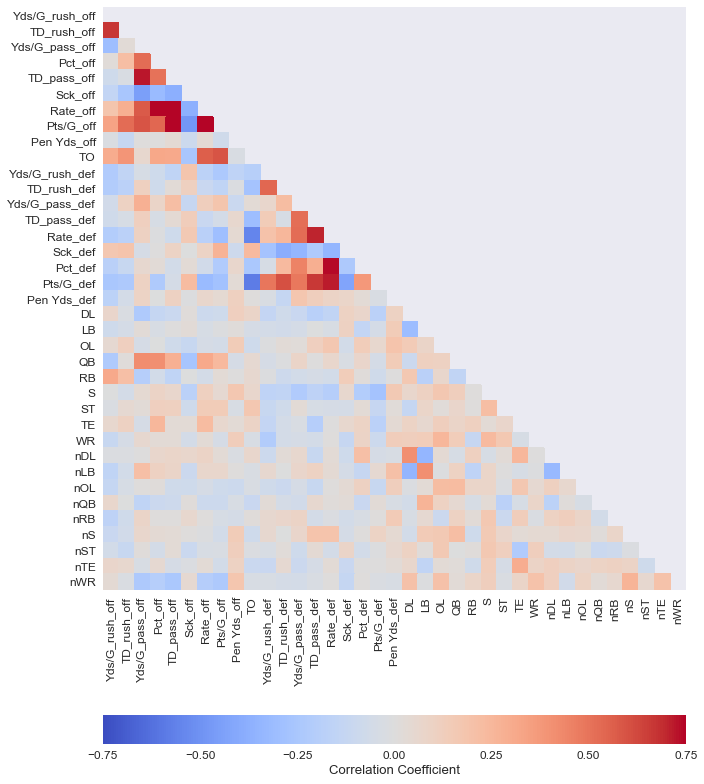

In [12]:
sns.set(font_scale=1.2)

corr = combined[combined.columns[2:-8]].corr()

import seaborn as sns
from matplotlib.colors import ListedColormap

labels = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
labels = labels.replace(np.nan,' ', regex=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

mask = np.triu(np.ones(corr.shape)).astype(np.bool)

_ = sns.heatmap(corr, mask=mask, vmin=-0.75, vmax=0.75, cmap='coolwarm', square=True, 
                ax=ax, cbar_kws={'shrink': .7, 'orientation': 'horizontal', 
                                 'label': 'Correlation Coefficient'})

mask = np.ones(mask.shape)-mask

_ = sns.heatmap(corr, mask=mask, cmap=ListedColormap(['None']),cbar=False, fmt='', 
                linewidths=1.5, linecolor='None', ax=ax)

plt.tight_layout()

Several of the offensive stats are correlated with one another. For instance passer rating is highly correlated with completion percentage. This is not surprising since completion percentage is one of the statistics used when calculating passer rating. Similar high correlations can be found in the defensive stats.

## Correlation Between Dependent Variable and Independent Variables

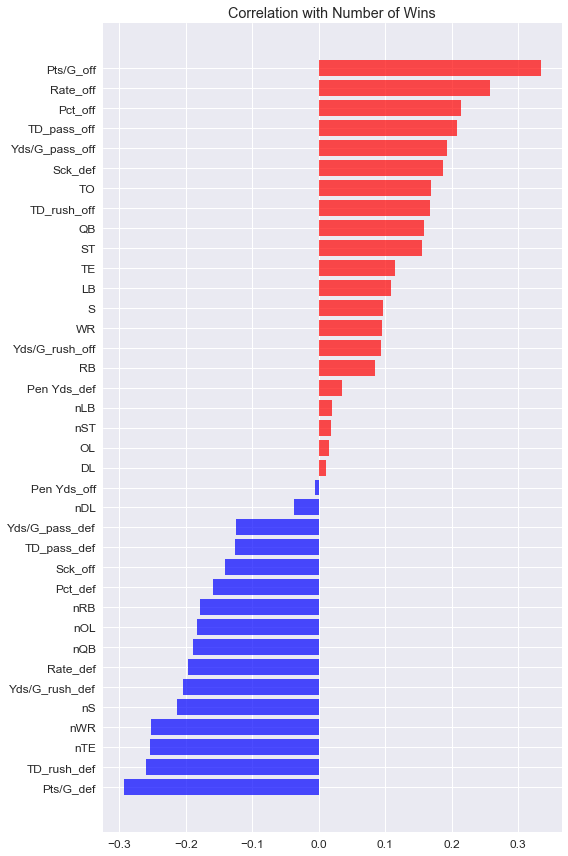

In [15]:
dv_corrs = {col: np.corrcoef(combined.dropna()[col].values, 
                             combined.dropna()['W'].values)[0, 1] 
            for col in combined.columns[2:-8]}
dv_corrs = sorted(dv_corrs.items(), key=operator.itemgetter(1))

var = np.array([x[0] for x in dv_corrs])
val = np.array([x[1] for x in dv_corrs])

mask_neg = val < 0
mask_pos = val > 0

fig, ax = plt.subplots(1, 1, figsize=(8, 12))

_ = ax.barh(range(len(var[mask_neg])), val[mask_neg], align='center', 
            color='blue', alpha=0.7)
_ = ax.barh(range(len(var[mask_neg]), len(var)), val[mask_pos], align='center', 
            color='red', alpha=0.7)

_ = ax.set_yticks(range(len(var)))
_ = ax.set_yticklabels(var)
_ = ax.set_title('Correlation with Number of Wins')

plt.tight_layout()

Previous season points per game scored by the offense and allowed by the defense have the highest correlation with my target variable (wins). Interestingly, number of wide tight ends, wide receivers, and secondary players has a relatively strong negative correlation with wins. My thinking on this is that if a team doesn't have a superstar at any of those positions, they stack many players to try and offset their lack of skill. 

## Testing for Difference Between Playoff Teams and Non-Playoff Teams

I'll perform a two tailed t-test for each of the independent variables for teams that made the playoffs against teams that did not make the playoffs. This is to see if there is a significant difference in the means of the two samples.

My hypothesis test for each variable will be:
* $H_0$: The means of the variable is the same between playoff teams and non-playoff teams
* $H_a$: The means of the variable is different between playoff teams and non-playoff teams

In [17]:
a = combined[combined['Playoffs'] == 0]['Yds/G_rush_off'].values
b = combined[combined['Playoffs'] == 1]['Yds/G_rush_off'].values

t, p = ttest_ind(a, b, equal_var=False)

print('{:^15} {:^8} {:^10}'.format('Variable', 't', 'p-value'))

for col in combined.columns[2:-8]:
    a = combined[combined['Playoffs'] == 0][col].values
    b = combined[combined['Playoffs'] == 1][col].values
    
    t, p = ttest_ind(a, b, equal_var=False)
    
    print('{:15} {:8.4f} {:10.6f}'.format(col, t, p), end='')
    if p <0.05:
        print('*')
    else:
        print('')

   Variable        t      p-value  
Yds/G_rush_off   -1.3679   0.173847
TD_rush_off      -1.5464   0.124654
Yds/G_pass_off   -1.5043   0.135187
Pct_off          -2.5114   0.013279*
TD_pass_off      -2.4308   0.016794*
Sck_off           0.8573   0.392858
Rate_off         -3.2726   0.001403*
Pts/G_off        -3.4884   0.000703*
Pen Yds_off       0.1320   0.895147
TO               -2.2181   0.028500*
Yds/G_rush_def    2.0906   0.038397*
TD_rush_def       2.9251   0.004098*
Yds/G_pass_def    0.9854   0.326524
TD_pass_def       1.0008   0.318638
Rate_def          1.8813   0.062105
Sck_def          -1.1861   0.237922
Pct_def           1.8031   0.073537
Pts/G_def         3.0900   0.002480*
Pen Yds_def      -0.7460   0.457284
DL               -0.7985   0.426104
LB               -1.1130   0.268160
OL                0.0011   0.999085
QB               -1.8185   0.071185
RB               -0.0186   0.985198
S                -0.3935   0.694544
ST               -1.5257   0.129552
TE               -1.

So there are 12 independent variables that have a significant difference in means between playoff teams and non-playoff teams. 